In [109]:
import os, sys
import rasterio
import argparse
import yaml
import numpy as np
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import pandas as pd
from argparse import Namespace
import matplotlib.pyplot as plt
os.chdir("/scratch/ewalt/pdm/rs-uncertainty/")

In [12]:
def pjoin(*subs): return Path(os.path.abspath(os.path.join(*subs)))

In [13]:
# load config
args = Namespace()
args.cfg = Path("./config/evaluate_testset.yaml")
with args.cfg.open("r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

In [193]:
projects = cfg["projects_east"]+cfg["projects_west"]+cfg["projects_north"]
with Path("/scratch/ewalt/pdm/rs-uncertainty/assets/data/pkl/2021-05-18_10-57-45/stats.yaml").open() as f:
    stats = yaml.safe_load(f)
labels_mean = np.array(stats["labels_mean"]).reshape(5,1,1)
labels_std = np.array(stats["labels_std"]).reshape(5,1,1)
# with pjoin(args.cfg["pkl_dir"], "stats.yaml").open("r", encoding="utf-8") as f:
#     stats = yaml.safe_load(f)
# labels_mean = np.array(stats["labels_stats"]["mean"])
# labels_std = np.array(stats["labels_stats"]["std"])

In [270]:
# iterate and standardize
variables = ['P95', 'MeanH', 'Dens', 'Gini', 'Cover']
def add(arr, source, state, pid):
    arr = arr.reshape(-1,)   
    data["number"].extend(arr.tolist())
    for variable in variables:
        data["variables"].extend([variable for _ in range(int(arr.shape[0]//5))])
    data["sources"].extend([source for _ in range(arr.shape[0])])
    data["states"].extend([state for _ in range(arr.shape[0])])
    data["project_id"].extend([pid for _ in range(arr.shape[0])])
# for mean_file in tqdm(cfg["pkl_dir"].glob('*_mean.tif')):
MAX_PROJECTS = 4
counter = 0
data = {
    "number": [],
    "variables": [],
    "sources": [],
    "states": [],
    "project_id": [],
}
for mean_file in Path("/scratch/ewalt/pdm/rs-uncertainty/results/2023-04-05_15-46-48").glob('*_mean.tif'):
    counter += 1
    # load data
    project = mean_file.stem.split('_')[0]
    if project not in projects: continue
    with rasterio.open(mean_file) as fh:
        mean = fh.read(fh.indexes)
    # with rasterio.open(pjoin(cfg['prediction_dir'], f"{project}_variance.tif")) as fh:
    with rasterio.open(pjoin("/scratch/ewalt/pdm/rs-uncertainty/results/2023-04-05_15-46-48", f"{project}_variance.tif")) as fh:
        variance = fh.read(fh.indexes)
    with rasterio.open(pjoin(cfg['gt_dir'], f"{project}.tif")) as fh:
        gt = fh.read(fh.indexes)
        gt_mask = fh.read_masks(1).astype(np.bool_)
    # print(gt.shape, gt_mask.shape, np.isnan(mean).shape)
    # standardize
    variance_after = variance/(labels_std)**2
    mean_after = (mean-labels_mean)/labels_std
    gt_after = (gt-labels_mean)/labels_std 
    # mask
    mean_mask = ~np.isnan(mean).all(0)
    print("mean_mask included in gt_mask?", (gt_mask[mean_mask==False]==False).all())
    print("gt_mask included in mean_mask?", (mean_mask[gt_mask==False]==False).all())
    mask = np.logical_and(~np.isnan(mean).all(0), gt_mask)
    # print(mask.shape)
    mean = mean[:,mask]
    variance = variance[:,mask]
    gt = gt[:,mask]
    mean_after = mean_after[:,mask]
    variance_after = variance_after[:,mask]
    gt_after = gt_after[:,mask]
    # add flatten
    add(mean, "before", "mean", project)
    add(mean_after, "after", "mean", project)
    add(variance, "before", "variance", project)
    add(variance_after, "after", "variance", project)
    add(gt, "before", "gt", project)
    add(gt_after, "after", "gt", project)
    if counter == MAX_PROJECTS: break
data = pd.DataFrame(data)
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True)

mean_mask included in gt_mask? False
gt_mask included in mean_mask? True
452743 50987
mean_mask included in gt_mask? False
gt_mask included in mean_mask? True
1012679 50987
mean_mask included in gt_mask? False
gt_mask included in mean_mask? True
912202 50987
mean_mask included in gt_mask? False
gt_mask included in mean_mask? True
354062 50987


In [260]:
data

,number,variables,sources,states,project_id
0,8.501150,P95,before,mean,354
1,10.065348,P95,before,mean,354
2,9.984715,P95,before,mean,354
3,9.769943,P95,before,mean,354
4,10.091656,P95,before,mean,354
...,...,...,...,...,...
9488845,389.225541,Cover,after,gt,1023
9488846,361.788061,Cover,after,gt,1023
9488847,389.225541,Cover,after,gt,1023
9488848,334.350582,Cover,after,gt,1023


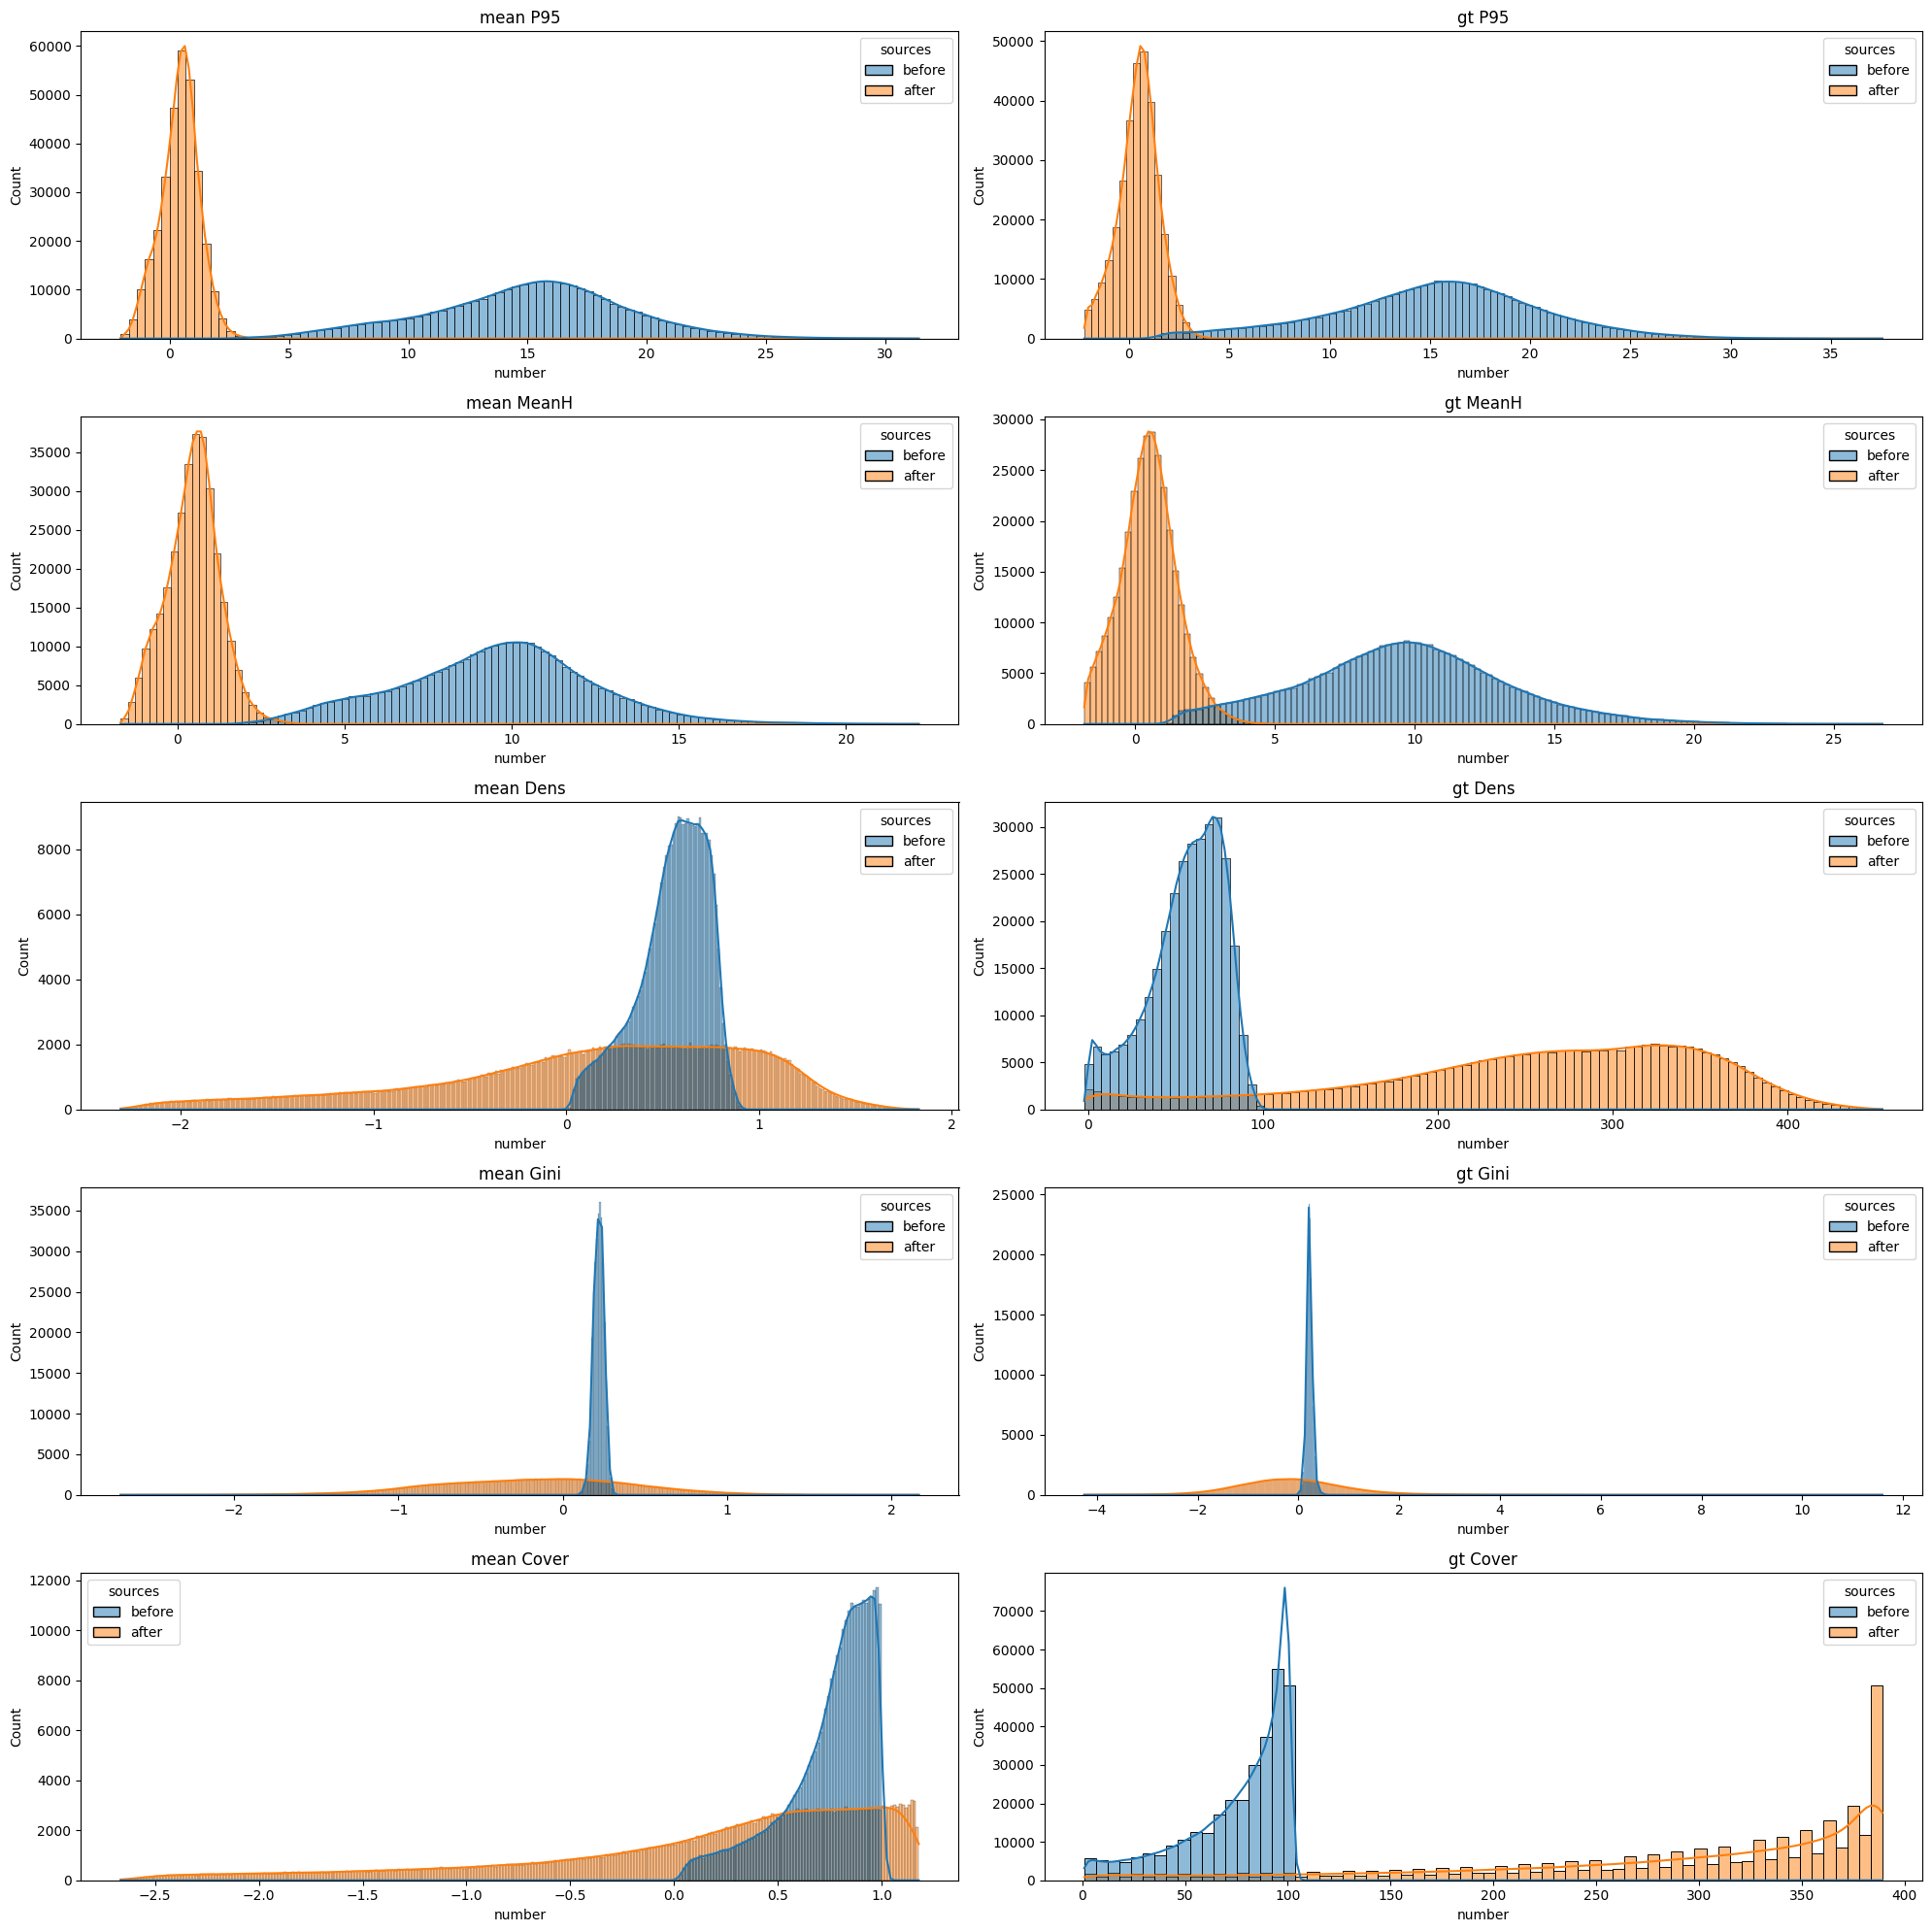

In [261]:
states = ["mean", "gt"]
fig, axs = plt.subplots(nrows=len(data.variables.unique()), ncols=len(states), figsize=(20,20))
for i, variable in enumerate(data.variables.unique()):
    for j, state in enumerate(states):
        if state=="variance": continue
        sub = data.copy()
        sub = sub[sub.variables==variable]
        sub = sub[sub.states==state]
        sns.histplot(data=sub, x="number", hue="sources", kde=True, ax=axs[i,j])
        axs[i,j].set_title(f"{state} {variable}")
plt.tight_layout()
plt.show()


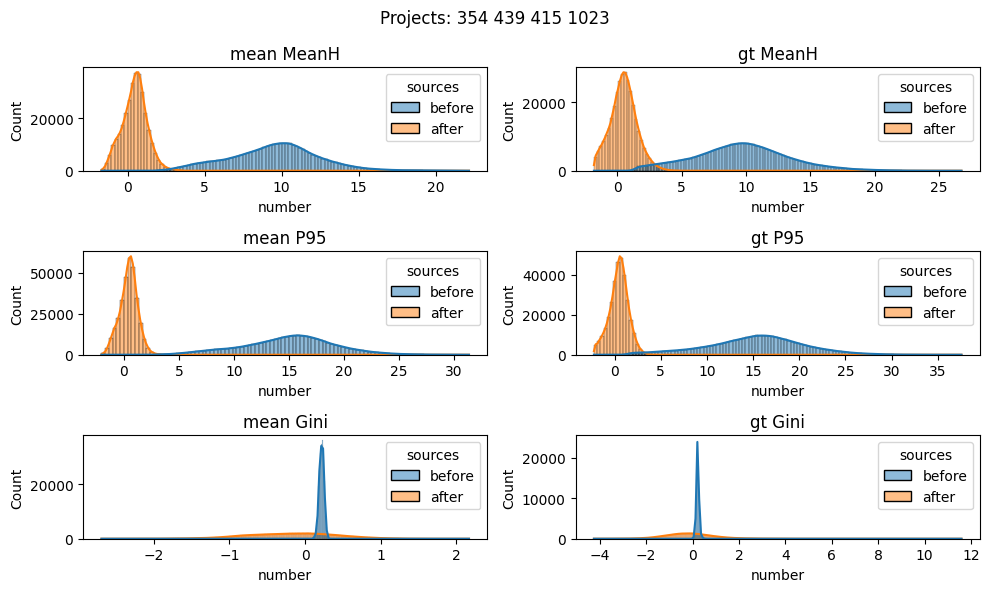

In [229]:
states = ["mean", "gt"]
variables = ["MeanH", "P95", "Gini"]
fig, axs = plt.subplots(nrows=len(variables), ncols=len(states), figsize=(10,6))
for i, variable in enumerate(variables):
    for j, state in enumerate(states):
        if state=="variance": continue
        sub = data.copy()
        sub = sub[sub.variables==variable]
        sub = sub[sub.states==state]
        sns.histplot(data=sub, x="number", hue="sources", kde=True, ax=axs[i,j])
        axs[i,j].set_title(f"{state} {variable}")
fig.suptitle("Projects: {}".format(" ".join(list(data.project_id.unique()))))
plt.tight_layout()
plt.savefig("notebooks/standardization_ok.png")
plt.show()

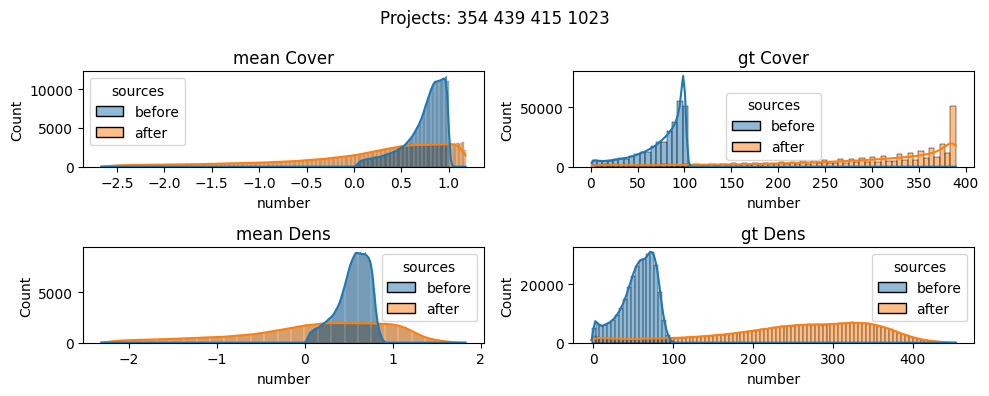

In [230]:
states = ["mean", "gt"]
variables = ["Cover", "Dens"]
fig, axs = plt.subplots(nrows=len(variables), ncols=len(states), figsize=(10,4))
for i, variable in enumerate(variables):
    for j, state in enumerate(states):
        if state=="variance": continue
        sub = data.copy()
        sub = sub[sub.variables==variable]
        sub = sub[sub.states==state]
        sns.histplot(data=sub, x="number", hue="sources", kde=True, ax=axs[i,j])
        axs[i,j].set_title(f"{state} {variable}")
fig.suptitle("Projects: {}".format(" ".join(list(data.project_id.unique()))))
plt.tight_layout()
plt.savefig("notebooks/standardization_issues.png")
plt.show()

In [231]:
data.project_id.unique()

array(['354', '439', '415', '1023'], dtype=object)

In [254]:
1664*480

798720

In [253]:
gt.shape, gt_mask.shape

((5, 23118), (1664, 480))

In [251]:
gt[:,gt_mask]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [245]:
np.isnan(mean).all(0).shape

(23118,)

In [235]:
np.isnan(mean).all(axis=0, keepdims=True).shape

(1, 23118)

In [121]:
data.query("states == 'gt' & variables == 'P95'").number.unique()

array([-9.99999000e+05,  7.33900023e+00,  1.21914997e+01, ...,
       -2.34945420e+00, -2.22382446e+00, -1.95827121e+00])

In [153]:
(gt==-9.99999000e+05).sum()/gt.reshape(-1,).shape[0]

0.35037935697115385

In [155]:
(gt<0).sum()/gt.reshape(-1,).shape[0]

0.35038561698717946

In [163]:
with rasterio.open(pjoin(cfg['gt_dir'], f"{project}.tif")) as fh:
    gt = fh.read(fh.indexes)
    gt_mask = fh.read_masks(1).astype(np.bool_)

In [169]:
([gt==-9.99999000e+05]==gt_mask).sum()/gt_mask.reshape(-1,).shape[0]

0.4139247796474359

In [170]:
gt.shape, gt_mask.shape

((5, 1664, 480), (1664, 480))

In [177]:
np.count_nonzero(((gt[0]==-9.99999000e+05)==gt_mask))/(gt_mask.shape[0]*gt_mask.shape[1])

0.07052033253205128

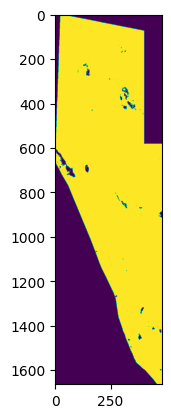

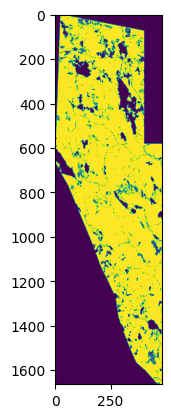

In [185]:
probably_ok = (gt[0]!=-9.99999000e+05)
definitely_ok = gt_mask
plt.imshow(probably_ok)
plt.show()
plt.imshow(definitely_ok)
plt.show()

In [183]:
np.logical_and(probably_ok

False

In [184]:
definitely_ok[0,0]

False

In [188]:
(np.isnan(mean)==([gt==-9.99999000e+05]))

array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  T